** This notebook is based on Geron's Hands-On Machine Learning, Chapter 3, as well as his <a href="https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb">classification notebook</a>. For theory on Naive Bayes and Stochastic Gradient Descent we provide references below.


In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [2]:
# a few auxiliary plotting functions for the MNIST dataset below
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")
    

# MNIST

In [3]:
import warnings
warnings.filterwarnings('ignore') 

In [4]:
import sklearn as skl
import pickle

try:
    print('trying loading pre-saved mnist data')
    with open('mnist.pkl', 'rb') as file:
        mnist = pickle.load(file)
        print('done')
except:
    print('failed loading pre-saved mnist... loading from repository')
    if skl.__version__ >= '0.22':
        from sklearn.datasets import fetch_openml
        mnist = fetch_openml('mnist_784', as_frame=False)    
    else:
        from sklearn.datasets import fetch_mldata
        mnist = fetch_mldata('MNIST original') # Depreciated in newer versions of sklearn
    
    print('saving locally')
    with open('mnist.pkl', 'wb') as file:
        pickle.dump(mnist, file)

mnist.data, mnist.target

trying loading pre-saved mnist data
done


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

In [5]:
X, y = mnist["data"], mnist["target"]
y = y.astype(int) # in mnist_784 data type is string-casted ints
X.shape, y.shape, 28*28

((70000, 784), (70000,), 784)

training point: 6265  is digit 6


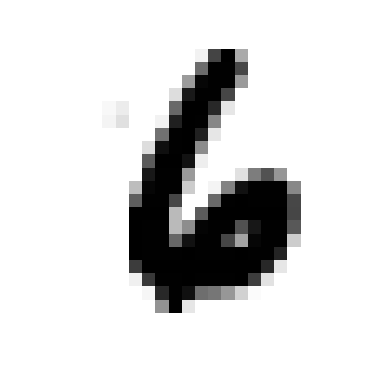

In [10]:
i = np.random.choice(len(X))
# i = 36000
some_digit = X[i]
plot_digit(some_digit)
print('training point:', i, ' is digit', int(y[i]))


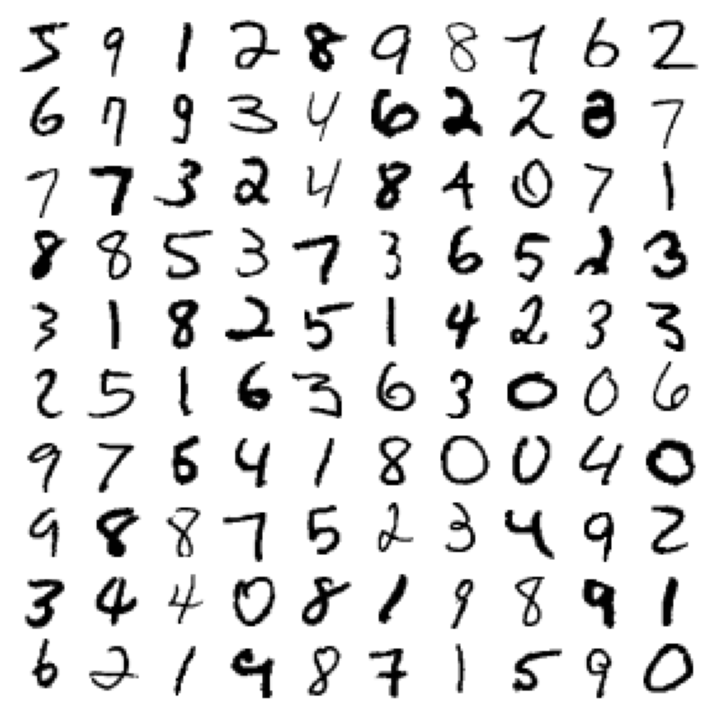

In [11]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

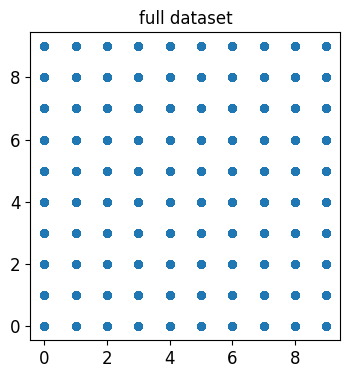

In [12]:
# Note that the test and training data are already prepared in this dataset
# this however is be depreciated in the Sklearn 0.20
fig, ax = plt.subplots(1,1, figsize=[4,4])
ax.scatter(y[:-1], y[1:], marker='o', linewidth=0)
ax.set_title('full dataset');


### Let's split train-test data and shuffle the training data

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Lets make our data binary-label
since this is a multi-label data, let's make it into binary data, by classifying if a digit is 5 or not

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [15]:
y_test_5.sum()

892

# A little more theory on binary classifiers

### Logistic Regression is slow for Big Data

One of the disadvantages of logistic regression is that it doesn't scale when the number of datapoints $N$ grows large. Remember our iterative algorithm to compute the $\beta$'s (e.g. Hastie Ch 4.4)

$$
\begin{align}
\beta^\text{new} & = \beta^\text{old} + (X^TWX)^{-1}X^TW(X\beta^\text{old}+W^{-1}(y-p))
\end{align}
$$

also requires us to compute the inverse of $(X^TWX)$ as well as the inverse of the Hessian $W=\partial^2{W}/\partial{\beta}\partial{\beta^T}$ which are both of size $N\times{N}$. So for large datasets the algorithm is slow. **Therefore the cell below will run very slow (do it at your own risk!):**

In [ ]:
train_me = False
if train_me:
    # This code runs really slow because logistic regression has to invert a 60,000x60,000 matrix!
    from sklearn.linear_model import LogisticRegression

    logit_slow_clf = LogisticRegression()
    logit_slow_clf.fit(X_train, y_train_5)

### One Solution (Stochastic) Gradient descent approach

**Gradient descent** methods are a great way to speed up the optimization when the dataset size grows large. We will come back to these methods later, but the basc idea is to optimize a likelihood

$$
\mathcal{L}(Y,X,B) = \frac{1}{N}\sum^N_{i=1}\ell(y_i,x_i,\beta_i)
$$

with respect to $B\equiv\{\beta_i\}^N_{i=1}$ by initializing $B=B_0$ and then iteratively update $B$ by:

$$
B_{n+1}=B_n-\gamma_n\nabla_B\mathcal{L}(Y,X,B_n)
$$

where the *learning rate* is typically chosen to be a small enough constant $\gamma_n=\gamma=const$ that the iteration will converge to a local minimum. The advantage of the above algorithm is that it does not involve matrix inversion. The disadvantage is that it doesn't guarantee global minimum convergence so it lacks robustness.

To make gradient descent robust, one typically adds noise as follows. In a **Stochastic Gradient Descent** (SGD):

- one feeds new training data $X_i, y_i$ in random batches of size $M$
- after each batch the gradient is computed and the update of $B$ is performed 
- since batches are chosen at random the gradient will be stochastic approximation of the full data set gradient 
- therefore the calculation is more robust to nose.


We will come back to SGD methods in later lectures, but if you are curious, read the <a href="https://en.wikipedia.org/wiki/Stochastic_gradient_descent">SGD Wiki page</a>

### SGD For logistic regression
For logistic regession the SGD algorithm is implemented in the 
<a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier">SGDClassifier class</a>. In order to have logistic regression, we need to specify the loss parameter to be 'log'. This amounts
<a href="http://scikit-learn.org/stable/modules/sgd.html">to optimizing the following loss function</a>:

$$
\begin{align}
\mathcal{L}(w,b|Y,X)&=\frac{1}{N}\sum^N_{i=1}\ell(w,b|y_i,x_i)+\alpha{R}(w)\\
&=\frac{1}{N}\sum^N_{i=1}\{y_i\log{p}(w,b|x_i)+(1-y_i)\log(1-p(w,b|x_i)\}+\alpha{R}(w)
\end{align}
$$

where $p(w,b|x)=\exp(w^Tx+b)/(1+\exp(w^Tx+b))$ and $w$ and $b$ are are the weight and bias parameters. The SGDClassifier then applies the SGD algorithm to the above loss.

Let's instantiate a SGD Logistic regression classifier:

In [ ]:
y_train_5[y_train_5]

In [16]:
from sklearn.linear_model import SGDClassifier

#this loss corresponds to logistic regression
logit_clf = SGDClassifier(
    random_state=42, loss='log_loss', max_iter=100, tol=1e-5) 
logit_clf.fit(X_train, y_train_5)


SGDClassifier(loss='log_loss', max_iter=100, random_state=42, tol=1e-05)

### As an aside, here is also the LDA another classifier
### - suffers from the same curse (of matrix inversion) curse

In the LDA (Hastie Ch. 4) one parametrizes the conditional likelihood ratio to be quadratic:

$$
\log\frac{P(G=k|X=x)}{P(G=\ell|X=x)}\propto\delta_k(x)=x^T\Sigma^{-1}\mu_k-\frac{1}{2}\mu^T_k\Sigma^{-1}\mu_k+\log\pi_k
$$

However the estimation of $\Sigma$ also involves matrix inversion:

$$
\hat\Sigma=\frac{1}{N-K}\sum^K_{k=1}\sum_{g_i=K}(x_i-\hat\mu_k)(x_i-\hat\mu_k)^T
$$

In [ ]:
train_me = False
if train_me:
    # This is very slow! Run this at your own risk!
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    lda_clf = LinearDiscriminantAnalysis()
    lda_clf.fit(X_train, y_train_5)

### Naive Bayes classifier
Similarly to the LDA, the Naive Bayes Classifier (see Hastie Ch. 6.6.3) models the log-likelihood ratio:

$$
\log\frac{P(G=k|X=x)}{P(G=\ell|X=x)}=\log\frac{\pi_k{f}_k(X)}{\pi_\ell{f}_\ell(X)}
$$

But instead of assuming a linear in $x$ log-likelihood ratio as in the LDA case (Hastie, eq 4.9), the NB classifier assumes that given a class $G=j$ the features $X_k$ are independent:

$$
f_j(X)=P(X|G=j)=\prod^p_{k=1}f_{jk}(X_k)
$$

so that the log-likelihood ratio becomes:

$$
\log\frac{P(G=k|X=x)}{P(G=\ell|X=x)}=\log\frac{\pi_k}{\pi_\ell}+\sum^p_{s=1}\log\frac{f_{ks}(X_s)}{f_{\ell{s}}(X_s)}
$$

Note that:
- the independence of features given a class may only be approximately correct if the number of features is large. These types of classifiers are usually a good choice for document classifiers (say spam classifiers) where the features of each document are the frequency of occurence of each of the words in the given language (a large feature space)
- the NB classifier is usually fast, because one only needs to estimate marginal conditional distributions of the data, $f_{jk}$. E.g. conditional on $G=j$ what is the distribution of the $k-$th feature? We will soon learn methods to efficiently estimate such marginal distributions.
- Under what conditions is the Naive Bayes classifier the same as the LDA classifier?

### Gaussian Naive Bayes classifier
The simplest choice of a marginal conditional feature distribution is a Gaussian conditional:

$$
P(X_k|G=j)=f_{jk}=\frac{1}{\sqrt{2\pi\sigma^2_j}}\exp(-\frac{(x_k-\mu_j)^2}{2\sigma^2_j})
$$

which corresponds to the <a href="http://scikit-learn.org/stable/modules/naive_bayes.html">GaussianNB</a> class in scikit-learn

In [17]:
#this is the Gaussian Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train_5)

GaussianNB()

Is this digit 5? Classifier says: True


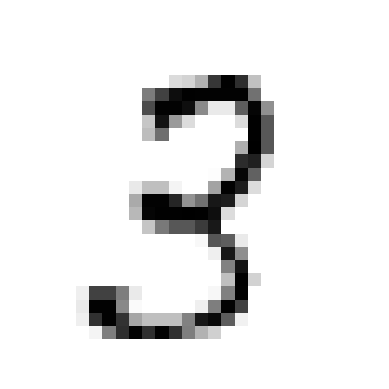

In [21]:
model = gnb_clf
# model = logit_clf
# d = some_digit # remember this is a 5
d = X_train[np.random.choice(len(X_train))]
plot_digit(d)
print('Is this digit 5? Classifier says:', model.predict([d])[0])

# Performance Measures
Let's see which classifier is better - SGD LogisticRegression or Gaussian Naive Bayes

### Cross-validation scoring

In [22]:
# model = logit_clf
model = gnb_clf
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(model)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.24425
0.2502
0.2539


### Let's compare the two classifiers with Scikit-learn's own cross_val_score function

In [23]:

from sklearn.model_selection import cross_val_score
for model in [logit_clf, gnb_clf]:
    print(model.__class__)
    cv_score = cross_val_score(
        model, X_train, y_train_5, cv=3, scoring="accuracy")
    print("cv_score", cv_score, '\n')

<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
cv_score [0.966   0.96775 0.9647 ] 

<class 'sklearn.naive_bayes.GaussianNB'>
cv_score [0.2523 0.2501 0.2447] 



### It seems above that the Gaussian NB is much worse than the SGD Classifier. Can you find reasons why?

### Let's implement another really dumb classifier 

In [24]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [25]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.9067 , 0.91325])

### The Never5Classifier has better accuracy than the Gaussian NaiveBayes and almost the same as the SGD classifier! 

### Can you think of why?

### Confusion Matrix
Let's look at the Confusion Matrix which counts how many times class A was predicted as class B. For the two class problem, it is defined as:

$$
C  =
\begin{bmatrix}
    N_{A,A} & N_{A,B} \\
    N_{B,A} & N_{B,B} \\
\end{bmatrix}
=
\begin{bmatrix}
    N_{actual=A,predict=A} & N_{actual=A,predict=B} \\
    N_{actual=B,predict=A} & N_{actual=B,predict=B} \\
\end{bmatrix} 
$$

Using the cross_val_predict method in sklearn we can split the train data in to 3 subsets and for each subset, we use the rest of the train data to predict it. This way we end up with predictions y_train_pred for each training sample, from which we can compute the confusion matrix


In [26]:
models = [logit_clf, gnb_clf, never_5_clf]

In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

dict_y_tpred={}
for model in models:
    y_train_pred = cross_val_predict(model, X_train, y_train_5, cv=3)
    dict_y_tpred[model.__class__] = y_train_pred
    print(model.__class__)
    print(confusion_matrix(y_train_5, y_train_pred))
    print('')

<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
[[53981   598]
 [ 1433  3988]]

<class 'sklearn.naive_bayes.GaussianNB'>
[[ 9603 44976]
 [   82  5339]]

<class '__main__.Never5Classifier'>
[[54579     0]
 [ 5421     0]]



###  Note how the Never5Classifier is correct 90% of the time because the training data is 9-fold unbalanced. In terms of the confusion matrix:

$$
\begin{align}
C  & =
\begin{bmatrix}
    N_{actual=non-5,predict=non-5} & N_{actual=5,predict=non-5} \\
    N_{actual=non-5,predict=5} & N_{actual=5,predict=5} \\
\end{bmatrix} \\
& =
\begin{bmatrix}
    \text{True Negatives} & \text{False Negatives} \\
    \text{False Positives} & \text{True Positives} \\
\end{bmatrix}
=
\begin{bmatrix}
    \text{TN} & \text{FN} \\
    \text{FP} & \text{TP} \\
\end{bmatrix}
\end{align}
$$

### A perfect classifier will have a diagonal confusion matrix

In [28]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall accuracy metrics
Precision and recall are defined as:
$$
\begin{align}
\text{precision}&=\frac{TP}{TP+FP}  - \text{what fraction of the positive outcomes do we predict to be positive}\\
\text{recall}&=\frac{TP}{TP+FN} - \text{what fraction of our positive predictions are true positive}
\end{align}
$$

Precision:
- measures how often our predictions are correct
- sometimes we want high precision classifiers. For example, a parent would want high precision for the web content filter for their kid.
- however precision alone is not enough! A good way to make a perfect precision classifier is to have it make a single prediction which is accurate
- obviously this would not be useful for say spam filters, because the classifier will accurately predict a single non-spam email but filter out all the other emails some of which are relevant to us!

That is why we need recall.

Recall:
- also called sensitivity, or true positive rate
- this is the ratio of the positive instances correctly detected by a classifier
- in the spam classifier case, this would be the fraction of the non-spam emails that the classifier detects correctly.

Sometimes, we prefer precision over recall and vice-versa. 
- for example, a parent would prefer a filter that rejects many good videos (i.e. low recall) but is very safe (high precision)
- but if you want to classify shop-lifters on camera, you want to have high recall (e.g. capture all shop lifters) even if you precision is low (e.g. sometimes you capture non-shop lifters)

A perfect classifier has $\text{precision}=\text{recall}=1$. 

You can see now that the Never5 classifier has zero precision and recall when it comes to predicting 5s. When it comes to predicting non-5s, it has perfect precision, but imperfect recall. This is a signature that our data is imbalanced.


In [29]:
from sklearn.metrics import precision_score, recall_score

for mclass in dict_y_tpred.keys():
    y_train_pred = dict_y_tpred[mclass]
    cm = confusion_matrix(y_train_5, y_train_pred)
    precision = precision_score(y_train_5, y_train_pred)
    recall = recall_score(y_train_5, y_train_pred)
    print(mclass,':')
    print('precision:', precision, cm[1,1]/(cm[1,1] + cm[0,1]))
    print('recall:', recall, cm[1,1]/(cm[1,1] + cm[1,0]))
    print('\n')
    

<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> :
precision: 0.8696031399912778 0.8696031399912778
recall: 0.7356576277439587 0.7356576277439587


<class 'sklearn.naive_bayes.GaussianNB'> :
precision: 0.10611149756533837 0.10611149756533837
recall: 0.9848736395498986 0.9848736395498986


<class '__main__.Never5Classifier'> :
precision: 0.0 nan
recall: 0.0 0.0




### What can you deduce from the above results? How do you compare the SGD Logit classifier to the Gaussian NB classifier?

# Precision-Recall Tradeoff
# precision: Out of all the instances predicted as positive, how many were actually positive?
# recall: Out of all the actual positive instances, how many were correctly predicted as positive by the classifier?

Suppose that instead of the actual predictions, we want to get their *scores*. E.g. the SGD classifier has a decision_function() method which produces the score for a given input. The higher the score, the more confident the classifier is that the input classifies as True: 

In [31]:
y_score = logit_clf.decision_function([some_digit])
y_pred = logit_clf.predict([some_digit])
y_score, y_pred

(array([-12986.85300155]), array([False]))

#### Actually the SGD classifier uses threshold=0, which corresponds to

In [32]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

#### But had we used a different threshold we could've gotten a different result

In [33]:
threshold = -400000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([ True])

#### Let's get the scores for all our predictions using the cross_val_predict method

In [34]:
y_scores = cross_val_predict(logit_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores

array([-36628.87251418, -16601.16875713, -15638.48227002, ...,
       -29380.249489  ,  -2874.37474826, -56904.66845862])

<Axes: >

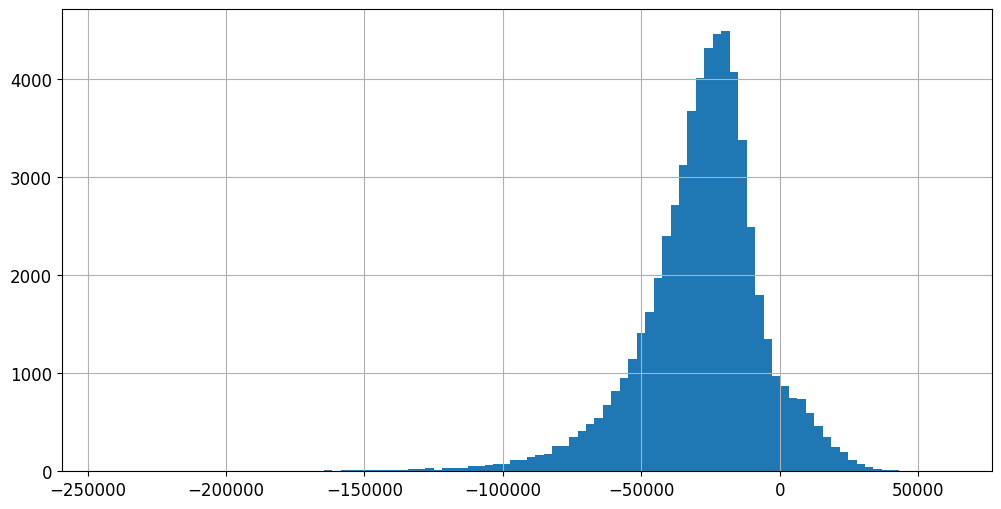

In [35]:
import pandas as pd
pd.Series(y_scores).hist(bins=100, figsize=(12,6))

Note: there is an [issue](https://github.com/scikit-learn/scikit-learn/issues/9589) introduced in Scikit-Learn 0.19.0 where the result of `cross_val_predict()` is incorrect in the binary classification case when using `method="decision_function"`, as in the code above. The resulting array has an extra first dimension full of 0s. We need to add this small hack for now to work around this issue:

In [36]:
y_scores.shape

(60000,)

In [37]:
y_scores[:5]

array([-36628.87251418, -16601.16875713, -15638.48227002, -64740.67699761,
       -45015.50749439])

In [38]:
# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

#### SKlearn has a percision_recall_curve method which varies the threshold and for each threshold value it computes the precision and recall scores

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(
    y_train_5, y_scores)

### The plot below illustrates the precision-recall tradeoff

Basically, if we increase the threshold on our classifier, we will increase the clasifier's precision as we will only classify the true positives that have a very high score. But at the same time we will miss on those true positives which the classifier gave a low score. So we will decrease the recall:


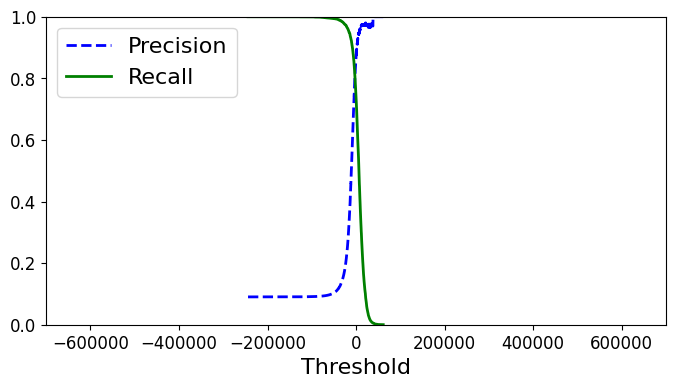

In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

### In the case of the Gaussian Naive Bayes model, instead of score function there is a predict_proba function

But as you can see below, the probability for the naive bayes is not a continuum, but a discrete variable, so varying the threshold doesn't really do anything for us

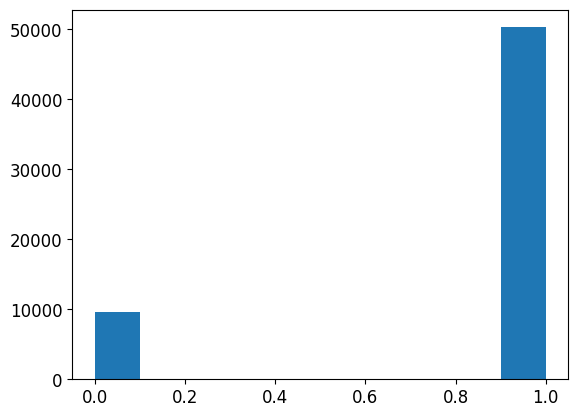

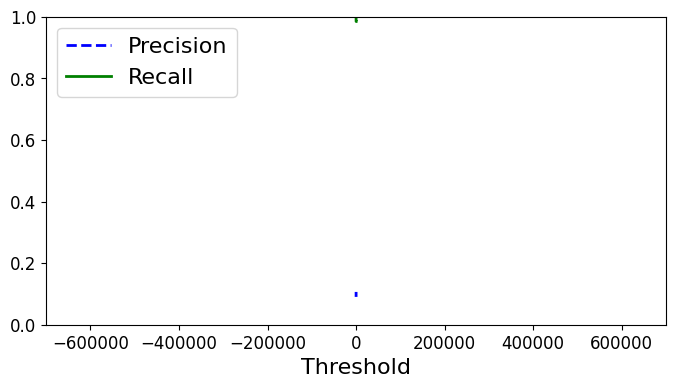

In [41]:
y_scores_nb = cross_val_predict(gnb_clf, X_train, y_train_5, cv=3,
                             method="predict_proba")[:, 1]
plt.hist(y_scores_nb)
plt.show()

precisions_nb, recalls_nb, thresholds_nb = precision_recall_curve(
    y_train_5, y_scores_nb)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_nb, recalls_nb, thresholds_nb)
plt.xlim([-700000, 700000])
plt.show()

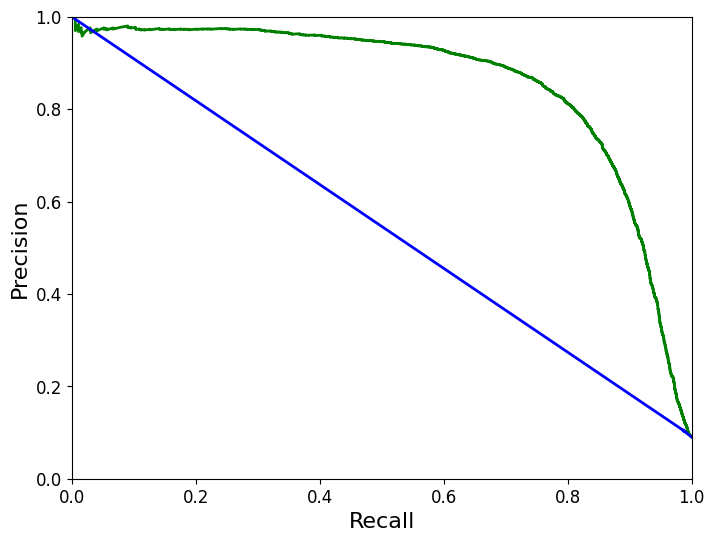

In [43]:
def plot_precision_vs_recall(precisions, recalls, color='b-'):
    plt.plot(recalls, precisions, color, linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls, color='g-')
plot_precision_vs_recall(precisions_nb, recalls_nb)
plt.show()

### How does the P-R curve look for a great classifier? Is the SGD a great classifier?

- In general, when we compare two classifiers it only makes sense to compare their precision for fixed recall or vice versa.
- Which one of the two classifiers is better: the NGB or the SGD Logistic Regression?


# ROC Receiver Operating Characteristic curves

The Receiver Operating Characteristic curve is another way to measure the accuracy of a classifier. Basically we plot the True Positive rate vs the False Positive rate.

$$
\begin{align}
\text{TP Rate} & = \frac{TP}{P}=\frac{TP}{TP+FN} = \frac{估+，是+}{是 +}\\
\text{FP Rate} & = \frac{FP}{N}= \frac{FP}{FP+TN}= \frac{估+，是-}{是 -}\\
\end{align}
$$

- A pure random classifier will have a diagonal ROC curve. Can you see why?

In a pure random classifier, the probability of predicting a positive class is equal to the probability of predicting a negative class. This means that the classifier is just as likely to predict a true positive as it is to predict a false positive. Therefore, as the classifier's threshold varies, the increase in true positives is always accompanied by a proportional increase in false positives.

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_train_5, y_scores_nb)

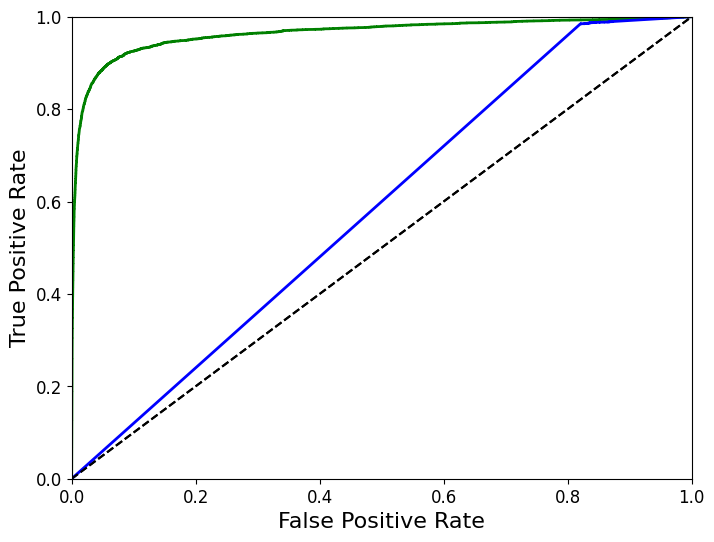

In [45]:
def plot_roc_curve(fpr, tpr, label=None, color='b-'):
    plt.plot(fpr, tpr, color, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr, color='g-')
plot_roc_curve(fpr_nb, tpr_nb)
plt.show()

#### Let's compare to another SGD model with a different loss function

In [51]:
#this loss corresponds to SVM as we will see later
hinge_clf = SGDClassifier(random_state=42, loss='hinge', max_iter=5, tol=1e-10) 
hinge_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=5, random_state=42, tol=1e-10)

In [52]:
y_scores_hinge = cross_val_predict(hinge_clf, X_train, y_train_5, cv=3,
                                    method="decision_function")

# hack to work around issue #9589 introduced in Scikit-Learn 0.19.0
if y_scores_hinge.ndim == 2:
    y_scores_hinge = y_scores_hinge[:, 1]
    
fpr_hinge, tpr_hinge, thresholds_hinge = roc_curve(
    y_train_5,y_scores_hinge)

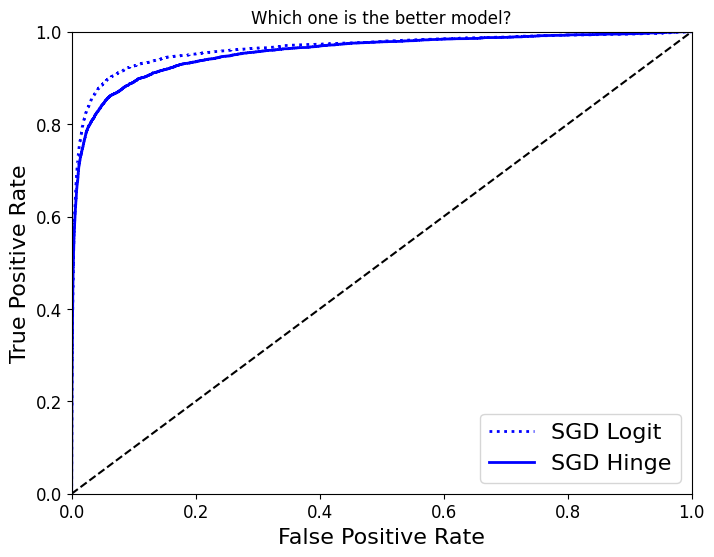

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD Logit")
plot_roc_curve(fpr_hinge, tpr_hinge, "SGD Hinge")
plt.legend(loc="lower right", fontsize=16)
plt.title('Which one is the better model?')
plt.show()

In [ ]:


from sklearn.metrics import roc_auc_score

print('Area under the curve:')
print(
    '\tSGD Logit AUC:', roc_auc_score(y_train_5, y_scores), '\n',
    '\tSGD Hinge AUC:', roc_auc_score(y_train_5, y_scores_hinge)) 

### Question: When do we use ROC vs Precision/Recall?


In summary, use the ROC curve when dealing with balanced datasets or when both types of classification errors are equally important, and use the Precision/Recall curve when dealing with imbalanced datasets or when focusing on the performance regarding the positive class.